In [1]:
import pandas as pd
import pickle
import numpy as np
import re

# Simpsons Kaggle

## Cleaning Data

In [2]:
%store -r df_nation

In [3]:
# df_nation.rename(columns={'levels':'1000-level'}, inplace=True)
conditions_frequency = [(df_nation['levels'] <= 3),
             (df_nation['levels'] == 4),
             (df_nation['levels'] >= 5) & (df_nation['levels']<= 14)]
values_frequency = ['1-3', '4', '5-14']
df_nation['levels_frequency'] = np.select(conditions_frequency, values_frequency)

conditions_coverage = [(df_nation['levels']<=14),
                        (df_nation['levels']>=15) & (df_nation['levels']<=25),
                      (df_nation['levels']>=26)]
values_coverage = [df_nation['levels'], 15, df_nation['levels']]

df_nation['levels_coverage'] = np.select(conditions_coverage, values_coverage)

In [4]:
df_simpsons = pd.read_csv('simpsons_script_lines.csv')

/Applications/anaconda3/envs/scrapping/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (4,5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df_simpsons

,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
0,9549,32,209,"Miss Hoover: No, actually, it was a little of ...",848000,True,464,3.0,Miss Hoover,Springfield Elementary School,"No, actually, it was a little of both. Sometim...",no actually it was a little of both sometimes ...,31
1,9550,32,210,Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?,856000,True,9,3.0,Lisa Simpson,Springfield Elementary School,Where's Mr. Bergstrom?,wheres mr bergstrom,3
2,9551,32,211,Miss Hoover: I don't know. Although I'd sure l...,856000,True,464,3.0,Miss Hoover,Springfield Elementary School,I don't know. Although I'd sure like to talk t...,i dont know although id sure like to talk to h...,22
3,9552,32,212,Lisa Simpson: That life is worth living.,864000,True,9,3.0,Lisa Simpson,Springfield Elementary School,That life is worth living.,that life is worth living,5
4,9553,32,213,Edna Krabappel-Flanders: The polls will be ope...,864000,True,40,3.0,Edna Krabappel-Flanders,Springfield Elementary School,The polls will be open from now until the end ...,the polls will be open from now until the end ...,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
158266,9544,32,204,Miss Hoover: (OFF LISA'S REACTION) I'm back.,831000,true,464,3.0,Miss Hoover,Springfield Elementary School,I'm back.,im back,2
158267,9545,32,205,"Miss Hoover: You see, class, my Lyme disease t...",839000,true,464,3.0,Miss Hoover,Springfield Elementary School,"You see, class, my Lyme disease turned out to ...",you see class my lyme disease turned out to be,10
158268,9546,32,206,Miss Hoover: Psy-cho-so-ma-tic.,842000,true,464,3.0,Miss Hoover,Springfield Elementary School,Psy-cho-so-ma-tic.,psy-cho-so-ma-tic,1
158269,9547,32,207,Ralph Wiggum: Does that mean you were crazy?,844000,true,119,3.0,Ralph Wiggum,Springfield Elementary School,Does that mean you were crazy?,does that mean you were crazy,6


In [6]:
from cleaning import clean_transcripts

round1 = lambda x: clean_transcripts(x)

df_simpsons['spoken_words'] = df_simpsons['spoken_words'].astype(str).apply(round1)
df_simpsons['spoken_words'] = df_simpsons['spoken_words'].apply(lambda x:x+' ')
not_str = df_simpsons[df_simpsons['character_id'].str.contains('[^\d]', na=False)].index.values
df_simpsons.drop(not_str, axis=0, inplace=True)
df_simpsons.dropna(subset=['character_id'], inplace=True)
df_simpsons['character_id'] = df_simpsons['character_id'].astype(int)

### Simpsons characteres by total number of lines

In [70]:
df_simpsons_lines = df_simpsons.groupby('raw_character_text').count().sort_values(by=['raw_text'], ascending=False)[['raw_text']][:20]
df_simpsons_lines

,raw_text
raw_character_text,
Homer Simpson,29842
Marge Simpson,14159
Bart Simpson,13777
Lisa Simpson,11502
C. Montgomery Burns,3172
Moe Szyslak,2864
Seymour Skinner,2443
Ned Flanders,2145
Grampa Simpson,1886


### Total number of words

In [8]:
df_simpsons_analysis = df_simpsons[['character_id', 'spoken_words']].groupby('character_id').sum()
df_simpsons_analysis = df_simpsons_analysis.reset_index()
df_simpsons_analysis.sort_values(by='character_id')
df_simpsons_analysis['tokens'] = df_simpsons_analysis['spoken_words'].apply(lambda x:len(x.split()))
#Top 100 characters
df_simpsons_analysis = df_simpsons_analysis.sort_values('tokens', ascending=False)[:100]
df_simpsons_analysis = df_simpsons_analysis.reset_index(drop=True)
df_simpsons_analysis

,character_id,spoken_words,tokens
0,2,never thrown a party what about that big bash ...,288596
1,1,lisa tell your father homer you are not allowe...,134192
2,8,victory party under the slide hey thanks for y...,117468
3,9,where s mr bergstrom that life is worth living...,106054
4,15,must turn over got to greet dignitaries absolu...,38266
...,...,...,...
95,238,that s right michael jackson the thriller h...,777
96,6,ew a bug nan it s your turn jimbo hm someone s...,769
97,2065,hey guys c amon shut up oh yes believe me my g...,765
98,2304,i am an orphan from capitol city and those who...,737


In [9]:
df_character = df_simpsons[['character_id', 'raw_character_text']]
df_character = df_character.drop_duplicates('character_id').reset_index(drop=True).sort_values('character_id')
df_character = pd.merge(df_simpsons_analysis, df_character, on='character_id')[['character_id', 'raw_character_text', 'tokens']][:100]
df_character = df_character.reset_index()
df_character['index'] = df_character['index'].apply(lambda x:'index'+str(x))
df_character

,index,character_id,raw_character_text,tokens
0,index0,2,Homer Simpson,288596
1,index1,1,Marge Simpson,134192
2,index2,8,Bart Simpson,117468
3,index3,9,Lisa Simpson,106054
4,index4,15,C. Montgomery Burns,38266
...,...,...,...,...
95,index95,238,Marty,777
96,index96,6,Dewey Largo,769
97,index97,2065,Drederick Tatum,765
98,index98,2304,Armin,737


# Exploratory Data Analysis

### Document-Term Matrix

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
import scipy.sparse
cv_transcripts = CountVectorizer()#only misleading words excluded for the analysis
cv_matrix_transcripts = cv_transcripts.fit_transform(df_simpsons_analysis['spoken_words'])
df_dtm = pd.DataFrame.sparse.from_spmatrix(cv_matrix_transcripts, index=df_simpsons_analysis.index,
                                           columns=cv_transcripts.get_feature_names())

In [11]:
df_dtm = df_dtm.T

### Formulas

In [12]:
#behaviour
def get_frames(indices, dtm, thousand_level=None): #, thousand_level ['4'], ['5-14']
    """1. The df_dtm gives the number of times a word (all_forms) shows up in an episode/movie
       2. Then its joined to get the level and base_forms of each word
       3. The final df has the words counted for each episode so it can be seen base_forms repetition in the final df"""
    frames = []
    for index in indices:
        df_count_words = dtm[[index]].loc[dtm[index]!=0]
        df_count_words = df_count_words.reset_index()
        df_count_words.rename(columns={"index": "all_forms", index: "count"}, inplace=True)

        df_count_words_level = pd.merge(df_count_words, df_nation[['base_forms', 'all_forms',
                                'levels_frequency', 'levels', 'levels_coverage']], how='left', on='all_forms')
        df_count_words_level = df_count_words_level.dropna() ##INNER JOIN
        if thousand_level is not None:
            df_count_words_level = df_count_words_level[df_count_words_level['levels_frequency'].isin(thousand_level)]
        frames.append(df_count_words_level)
    df_count_words_level = pd.concat(frames)
    return df_count_words_level

def get_count(df_movie_nation):
    """Grouping by base_forms of word and summing their number of encounters
    Note: the 'count' column type in most cases is 'SPARSE NUMPY INT'. Then I have to use the 
    first 2 lines in the 'try' block to get 'int'. However, for some reason some columns after
    concatenating (in def get_frames)  are 'int'values. They go straigt to the 'except' block """
    try:
        int_value = [i.item() for i in df_movie_nation['count']]
        df_movie_nation['count'] = int_value
        df_count = df_movie_nation.groupby(by=['base_forms']).sum().reset_index()
        df_count = df_count.rename(columns={'count':'base_forms_encounters'})
        df_count = df_count.sort_values(by=['base_forms_encounters'], ascending=False)
    except:
        df_count = df_movie_nation.groupby(by=['base_forms']).sum().reset_index()
        df_count = df_count.rename(columns={'count':'base_forms_encounters'})
        df_count = df_count.sort_values(by=['base_forms_encounters'], ascending=False)
    return df_count

def get_statistics(df_movie_nation, df_count):
    """We merge and only get the root encounters to have a clean df when presenting data"""
    df_movie_nation.drop_duplicates(['base_forms'], inplace=True)
    df_movie_nation.drop(['all_forms','count'], axis=1, inplace=True)#Dropping columns from the df created in get_frames
    df_movie_nation = pd.merge(df_movie_nation, df_count, on='base_forms')[['base_forms_encounters']]

    conditions = [
    (df_movie_nation['base_forms_encounters'] == 1),
    (df_movie_nation['base_forms_encounters'] == 2),
    (df_movie_nation['base_forms_encounters'] >= 3) & (df_movie_nation['base_forms_encounters'] <= 4),
    (df_movie_nation['base_forms_encounters'] >= 5) & (df_movie_nation['base_forms_encounters'] <= 7),
    (df_movie_nation['base_forms_encounters'] >= 8) & (df_movie_nation['base_forms_encounters'] <= 9),
    (df_movie_nation['base_forms_encounters'] >= 10)
    ]
    values = ['1', '2', '3-4', '5-7', '8-9', '10+'] ###
    df_movie_nation['range_encounters'] = np.select(conditions, values)
    
    df_statistics = df_movie_nation.groupby('range_encounters').count()
    total = np.sum(df_statistics['base_forms_encounters'])
    #### APPLYING ON ROOT_encounter (shouldn't be no blanks in that column)
    df_statistics['%'] = df_statistics['base_forms_encounters'].apply(lambda x: round((int(x)/int(total))*100))
    df_statistics.sort_values(by=['%'], ascending=False)
    
    df_total_word_families = pd.DataFrame(df_statistics.sum()).T.rename(index={0:'Total word families'})
    df_statistics = df_statistics.append(df_total_word_families)
    df_tokens = pd.DataFrame(df_movie_nation[['base_forms_encounters']].sum(), columns=['base_forms_encounters'])
    df_tokens.rename(index={'base_forms_encounters':'Tokens'}, inplace=True)
    df_statistics = df_statistics.append(df_tokens)
    df_statistics = df_statistics.fillna(0)
    return df_statistics

### What the Top 10 characters say?

In [13]:
dict_simpsons = {}
levels = ['4', '5-14']
for level in levels:
    for index in df_simpsons_analysis.index.values[:10]:
        df_character_vocabulary = get_frames([index], df_dtm, [level])
        df_count= get_count(df_character_vocabulary)
        dict_simpsons['index%s_lvl%s' % (index, level)] = df_count

### What each character repeat the most (all levels)

In [14]:
df_vocabulary_simpsons = pd.concat(dict_simpsons)[['base_forms', 'base_forms_encounters']].reset_index()
df_vocabulary_simpsons.drop('level_1', axis=1, inplace=True)
df_vocabulary_simpsons['lvl'] = df_vocabulary_simpsons['level_0'].apply(lambda x:x.split('_')[1])
df_vocabulary_simpsons['level_0'] = df_vocabulary_simpsons['level_0'].apply(lambda x:x.split('_')[0])
df_vocabulary_simpsons.rename(columns={'level_0':'index'}, inplace=True)
df_vocabulary_simpsons = pd.merge(df_vocabulary_simpsons, df_character[['index', 'raw_character_text']])
df_vocabulary_simpsons
# for i in df_vocabulary_simpsons.values:
#     print(i[1]+'|'+str(i[2])+'|'+i[3]+'|'+i[4])

,index,base_forms,base_forms_encounters,lvl,raw_character_text
0,index0,jerk,72,lvl4,Homer Simpson
1,index0,thou,46,lvl4,Homer Simpson
2,index0,robot,38,lvl4,Homer Simpson
3,index0,hug,38,lvl4,Homer Simpson
4,index0,precious,36,lvl4,Homer Simpson
...,...,...,...,...,...
14935,index9,freak,1,lvl5-14,Grampa Simpson
14936,index9,fraught,1,lvl5-14,Grampa Simpson
14937,index9,fragrant,1,lvl5-14,Grampa Simpson
14938,index9,foreclose,1,lvl5-14,Grampa Simpson


### Who has the highest % hard word in their lines?

In [15]:
df_vocabulary_character = pd.concat([
    df_character.set_index('raw_character_text'),
    df_vocabulary_simpsons.groupby('raw_character_text').sum(),
    df_simpsons_lines
], axis=1)[['raw_text', 'tokens', 'base_forms_encounters']] #total lines, total tokens, tokens lvl4+

In [16]:
df_vocabulary_character['%'] = round(100 * (df_vocabulary_character['base_forms_encounters']/
                                                   df_vocabulary_character['tokens']), 2)
df_vocabulary_character.sort_values('%', ascending=False)[:10]
# for i in df_vocabulary_character.sort_values('%', ascending=False).reset_index()[:10].values:
#     print(i[0] + ',' + f'{i[1]:.0f}'',' + f'{i[2]:.0f}'',' + f'{i[3]:.0f}'',' + f'{i[4]:.2f}')

,raw_text,tokens,base_forms_encounters,%
C. Montgomery Burns,3172.0,38266,2260.0,5.91
Seymour Skinner,2443.0,29601,1461.0,4.94
Krusty the Clown,1772.0,21873,1049.0,4.80
Ned Flanders,2145.0,24224,1099.0,4.54
Bart Simpson,13777.0,117468,5136.0,4.37
Grampa Simpson,1886.0,21125,868.0,4.11
Lisa Simpson,11502.0,106054,4328.0,4.08
Homer Simpson,29842.0,288596,11667.0,4.04
Moe Szyslak,2864.0,34627,1400.0,4.04
Marge Simpson,14159.0,134192,4413.0,3.29


# Sentiment Analysis

In [27]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [71]:
top_character_names = df_simpsons_lines.index.values
df_character_sentiment = df_simpsons[df_simpsons['raw_character_text'].isin(top_character_names)]
df_character_sentiment = df_character_sentiment[['raw_character_text', 'spoken_words']]

sid = SentimentIntensityAnalyzer()
df_character_sentiment.reset_index(inplace=True, drop=True)
# df_character_sentiment = df_character_sentiment[['spoken_words']]
df_character_sentiment[['neg', 'neu', 'pos', 'compound']] = df_character_sentiment['spoken_words'].apply(sid.polarity_scores).apply(pd.Series)##

In [72]:
df_character_sentiment.groupby('raw_character_text').mean().round(3).sort_values('neg', ascending=False)

,neg,neu,pos,compound
raw_character_text,,,,
Dr. Julius Hibbert,0.087,0.769,0.134,0.050
Kent Brockman,0.086,0.801,0.110,0.029
Grampa Simpson,0.083,0.794,0.109,0.037
Nelson Muntz,0.080,0.805,0.104,0.026
Chief Wiggum,0.080,0.788,0.125,0.060
Moe Szyslak,0.080,0.775,0.133,0.087
C. Montgomery Burns,0.079,0.767,0.143,0.097
Bart Simpson,0.079,0.782,0.124,0.051
Apu Nahasapeemapetilon,0.077,0.745,0.140,0.088


# Heatmap

In [537]:
df_who_speaks = df_simpsons.sort_values(['episode_id', 'timestamp_in_ms'])
list_who_speaks = list(df_who_speaks['raw_character_text'].values)
pair_characters = [list_who_speaks[i:i+2] for i in range(0,len(list_who_speaks),1)]
pair_characters.pop(-1)
pairs=[]
for i in pair_characters:
    pairs.append('-'.join(i))

In [538]:
count_elements = dict((i, pairs.count(i)) for i in set(pairs))

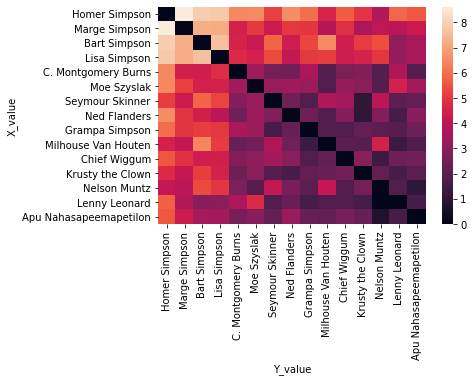

In [551]:
data_heatmap = sorted(count_elements.items(), key=lambda x:x[1], reverse=True)
data_heatmap = dict(data_heatmap)

x_list = [i.split('-')[0] for i in data_heatmap]
y_list = [i.split('-')[1] for i in data_heatmap]
z_list = [data_heatmap[i] for i in data_heatmap]

x_array = np.array(x_list)
y_array = np.array(y_list)
z_array = np.array(z_list)

df = pd.DataFrame.from_dict(np.array([x_array,y_array,z_array]).T)
df = df[df[0].isin(top_character_names)]
df = df[df[1].isin(top_character_names)]
df.columns = ['X_value','Y_value','Z_value']
df['Z_value'] = pd.to_numeric(df['Z_value'])

conditions = [df['X_value']==df['Y_value'],
              df['X_value']!=df['Y_value']]
values = [0, df['Z_value']]

df['Z_value'] = np.select(conditions, values)

df['scale'] = np.log(df['Z_value']+1)
pivotted= df.pivot('Y_value','X_value','scale')

pivotted = pivotted[list(top_character_names[:15])]
pivotted = pivotted.reindex(list(top_character_names[:15]))
pivotted = pivotted.T #rows speak to columns
pivotted = pivotted.fillna(0)
pivotted
#RdBu
#YlGnBu

sns.heatmap(pivotted,cmap=sns.cm.rocket,)
#             , vmin=-100, vmax=500)

In [41]:
df_homer = df_simpsons[df_simpsons['raw_character_text']=='Homer Simpson']
df_homer= df_homer[['spoken_words']]

sid = SentimentIntensityAnalyzer()
df_homer.reset_index(inplace=True)
# df_homer = df_homer[['spoken_words']]
df_homer[['neg', 'neu', 'pos', 'compound']] = df_homer['spoken_words'].apply(sid.polarity_scores).apply(pd.Series)##
df_homer[:10]
# df_homer.nlargest(10, ['neg'])

# df_homer['vader_polarity'] = np.where(df_homer['pos']>df_homer['neg'], 1, 0)
df_homer.mean()

,spoken_words,neg,neu,pos,compound
0,never thrown a party what about that big bash ...,0.096,0.810,0.094,-0.0150
1,bart did not get one vote oh this is the worst...,0.117,0.826,0.057,-0.4767
2,oh,0.000,1.000,0.000,0.0000
3,and,0.000,1.000,0.000,0.0000
4,hey just because i do not care does not mean i...,0.193,0.807,0.000,-0.3875
5,me,0.000,1.000,0.000,0.0000
6,i do not think you realize what you re saying,0.000,1.000,0.000,0.0000
7,did you hear that marge she called me a baboon...,0.324,0.676,0.000,-0.8020
8,go away,0.000,1.000,0.000,0.0000
9,lisa do not hold anything back you can tell me...,0.154,0.846,0.000,-0.4767


In [34]:
nltk.FreqDist(df_homer['spoken_words']).most_common(15)

[('nan ', 1930),
 (' ', 171),
 ('woo hoo ', 132),
 ('no ', 99),
 ('okay ', 62),
 ('why you little ', 54),
 ('huh ', 51),
 ('what ', 49),
 ('uh oh ', 45),
 ('yeah ', 42),
 ('marge ', 39),
 ('yes ', 37),
 ('oh ', 35),
 ('sorry ', 32),
 ('bart ', 26)]